# Analysing a sample ECG dataset
I have used The Long-Term AF Database and WFDB python package from __[PhysioNet](https://physionet.org)__ for my analysis.
## Reading and preprocessing the dataset
First import all needed packages. To install wfdb, one needs to run "pip install wfdb" on Linux.

In [1]:
import wfdb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as ov
import sklearn as sk

To download the dataset, use dl_databse function from wfdb package.

In [5]:
os.mkdir('data')
wfdb.dl_database('ltafdb', os.getcwd() + '/data')

Finished downloading files


Now read the data for a subject and find the sample numbers related to atrial fibrillation.

In [2]:
# For reading more about wfdb modules one can use help e.g. help(wfdb.rdsamp)
ann = wfdb.rdann('data/01', 'atr')
ann.symbol = pd.Series(ann.symbol)
ann.sample = pd.Series(ann.sample)
# Boolean is used to find the indices of the R-peaks that are annotated with "A"
boolean = pd.Series(ann.symbol=='A')
print(ann.sample[boolean].head(10))

5      6305
9      6676
22     7619
24     7814
26     7996
29     8200
32     8432
38     9047
54    10271
64    11040
dtype: int64


Do the same for normal heart beats.

In [3]:
boolean = pd.Series(ann.symbol=='N')
print(ann.sample[boolean].head(10))

1     5969
3     6119
4     6232
6     6412
7     6495
8     6602
10    6781
11    6848
12    6939
14    7093
dtype: int64


Based on the above values, the region between 6200 and 7200 seems to have normal heart beat, while the region between 7300 and 8300 has atrial fibrillation. Now, read the samples related to these two regions using rdsamp and plot these regions to see the difference between atrial fibrillation and normal beats.

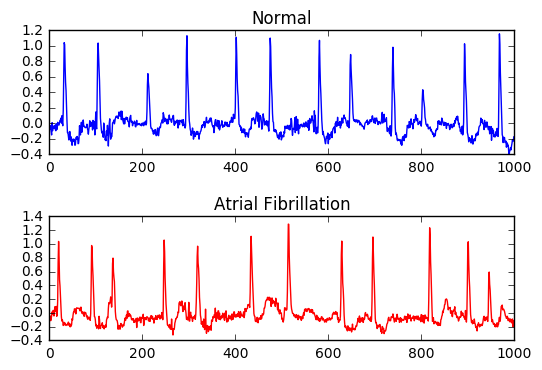

In [4]:
samp1 = wfdb.rdsamp('data/01',channels=[0], sampfrom=6200,sampto=7200)
samp2 = wfdb.rdsamp('data/01',channels=[0], sampfrom=7300,sampto=8300)
plt.subplot(2, 1, 1)
plt.title('Normal')
plt.plot(samp1[0])
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.5)
plt.title('Atrial Fibrillation')
plt.plot(samp2[0], color='red')
plt.show()

Define a class that is used to get every record, segment it, extract features, and label the segments.

In [5]:
class Subjects:
    """Subjects and their corresponding feature sets"""
    
    def __init__(self, sample, symbol):
        self.sample = pd.Series(list(sample)[1:])
        self.symbol = pd.Series(list(symbol)[1:])
        self.filtr()
        self.calculaterr()
        
# Changes the indices of a series to range(0,length_of_the_series)
    def reindex(self, series):
        series = series.reset_index()
        series.drop('index', axis=1, inplace=True)
        return(series[0])
    
# Interpolate heart beats with NaNs and divide heart beats into two classes: Normal and Abnormal
    def filtr(self):
        self.symbol.interpolate(inplace=True)
        self.sample.interpolate(inplace=True)
        self.sample = self.reindex(self.sample)
        self.symbol = self.reindex(self.symbol)
        self.symbol = self.symbol.replace('V', 'A')
        
# Claculate R-R intervals
    def calculaterr(self):
        self.rr = pd.Series(list(self.sample - self.sample.shift(1))[1:])

# Delete the end of the record if it is not divisible by segment length
    def cutend(self, n):
        self.sample = self.sample[0:(len(self.sample)//n)*n]
        self.symbol = self.symbol[0:(len(self.symbol)//n)*n]
        self.rr = self.rr[0:(len(self.sample)//n)*n]

# Calculate the sum of squares of distances between every two consecutive R-R intervals
    def dist(self, data):
        data = (data - data.shift(1))**2
        data = data.sum()
        return(data)
    
# Extract different features from the dataset (mean, standard deviation, RMSSD, and Normalised RMSSD)
    def extractfeatures(self, n):
        groups = self.rr.groupby(np.arange(len(self.rr))//n)
        self.means = groups.mean()
        self.sds = groups.std()        
        self.rmssd = np.sqrt(groups.apply(self.dist)/(n-1))
        self.nrmssd = self.rmssd/self.means

# Compare the number of Abnormal beats to a given threshold (n*r).
# If all beats in a segment are unclassified, it returns abnormal
    def compare(self, data, n, r):
        numQ = sum(data == 'Q')
        n -= numQ
        numA = sum(data == 'A')
        if numA >= n * r:
            return 'A'
        else:
            return 'N'

# Set the label of each segment by comparing the ratio of abnormal beats to a given threshold (r)
    def label(self, n, r):
        groups = self.symbol.groupby(np.arange(len(self.symbol))//n)
        self.labels = groups.apply(self.compare, n, r)

# Segment records, label the segments, and extract features from them.
    def segment(self, n, r):
        if (len(self.rr)%n):
            self.cutend(n)
        self.extractfeatures(n)
        self.label(n, r)

Read all ".atr" files and make them objects of the above class in order to segment them, extract features and label the segments.

In [6]:
list_of_files = os.listdir('data')
list_of_files = ['data/' + i[:-4] for i in list_of_files if i.endswith('.atr')]
data = pd.DataFrame({'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'label':[]},
                    columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
for item in list_of_files:
    ann = wfdb.rdann(item, 'atr')
    subj = Subjects(ann.sample, ann.symbol)
    subj.segment(10, 1/3)
    toappend = pd.DataFrame({'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'label':subj.labels}, columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
    data = pd.concat([data, toappend])
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

   mean         sd      rmssd    nrmssd label
0  61.7  13.391954  18.976594  0.307562     N
1  59.7   9.626930  15.260698  0.255623     N
2  70.8  16.102450  21.827607  0.308300     N
3  69.5  13.962251  24.000000  0.345324     N
4  63.8  15.626189  21.697414  0.340085     N
5  67.3  13.630440  19.813015  0.294398     N
6  61.2   9.554522  14.456832  0.236223     N
7  62.0  13.207742  16.200137  0.261293     N
8  60.4  12.429356  17.387735  0.287876     N
9  57.3   9.357706  16.100380  0.280984     N


## Over-sampling
Our dataset is imbalanced because most of the time the heart beats are normal. Therefore, normal data points outnumber atrial fibrillation cases. So, we need to generate some synthetic atrial fibrillation data points. I use imblearn package for this.

In [7]:
sm = ov.SMOTE()
data = data.loc[~data.isnull().any(axis=1),:]
sdata, slabel = sm.fit_resample(data.loc[:, data.columns != 'label'], data.loc[:,'label'])
sdata = pd.DataFrame(sdata, columns=['mean', 'sd', 'rmssd', 'nrmssd'])
slabel = pd.Series(slabel)
sdata['label'] = slabel

Let's see how the data looks before and after over-sampling. I only compare two features; standard deviaion and Normalised RMSSD.

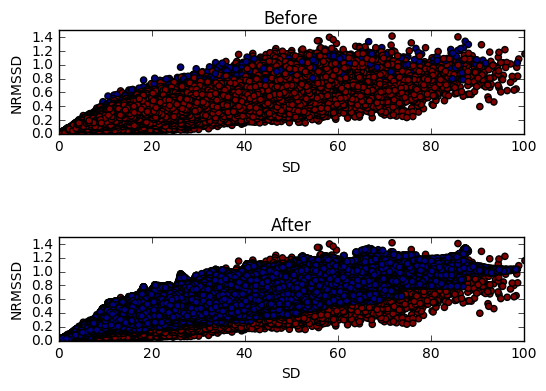

In [8]:
colors = data['label'] == 'N'
scolors = sdata['label'] == 'N'
plt.subplot(2, 1, 1)
plt.title('Before')
plt.scatter(data['sd'], data['nrmssd'], c=colors)
plt.xlim((0,100))
plt.xlabel('SD')
plt.ylim((0,1.5))
plt.ylabel('NRMSSD')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=1)
plt.title('After')
plt.scatter(sdata['sd'], sdata['nrmssd'], c=scolors)
plt.xlim((0,100))
plt.xlabel('SD')
plt.ylim((0,1.5))
plt.ylabel('NRMSSD')
plt.show()

## Classification
First, change the labels to numerical values and then separate the training and test sets.

In [9]:
le = sk.preprocessing.LabelEncoder()
le.fit(sdata['label'])
sdata['label'] = le.transform(sdata['label'])
# sdata.loc[sdata['label'] == 'A','label'] = 1
# sdata.loc[sdata['label'] == 'N','label'] = 0
# sdata['label'] = sdata['label'].astype('category')
train, test = sk.model_selection.train_test_split(sdata, test_size=0.2)

Now, run MLP on the training set.

In [10]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(7, 3))
mlp_clf.fit(train.loc[:, train.columns != 'label'], train.loc[:, 'label'])
mlp_res = mlp_clf.predict(test.loc[:, test.columns != 'label'])

Check the accuracy of the MLP prediction:

In [12]:
from sklearn.metrics import classification_report
print(classification_report(test['label'], mlp_res))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    175030
           1       0.87      0.87      0.87    175451

   micro avg       0.87      0.87      0.87    350481
   macro avg       0.87      0.87      0.87    350481
weighted avg       0.87      0.87      0.87    350481



Let's try decision tree as well.

In [13]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(train.loc[:, train.columns != 'label'], train.loc[:, 'label'])
dt_res = dt_clf.predict(test.loc[:, test.columns != 'label'])
print(classification_report(test['label'], dt_res))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95    175030
           1       0.96      0.94      0.95    175451

   micro avg       0.95      0.95      0.95    350481
   macro avg       0.95      0.95      0.95    350481
weighted avg       0.95      0.95      0.95    350481



And K-Nearest Neighbor:

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(train.loc[:, train.columns != 'label'], train.loc[:, 'label'])
knn_res = knn_clf.predict(test.loc[:, test.columns != 'label'])
print(classification_report(test['label'], knn_res))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    175030
           1       0.99      0.92      0.95    175451

   micro avg       0.95      0.95      0.95    350481
   macro avg       0.95      0.95      0.95    350481
weighted avg       0.95      0.95      0.95    350481



## Ensemble classification
Now, let's try an ensemble of classifiers using voting:

In [15]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier([('mlp', mlp_clf), ('dt', dt_clf), ('knn', knn_clf)])
voting.fit(train.loc[:, train.columns != 'label'], train.loc[:, 'label'])
voting_res = voting.predict(test.loc[:, test.columns != 'label'])
print(classification_report(test['label'], voting_res))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    175030
           1       0.98      0.93      0.95    175451

   micro avg       0.95      0.95      0.95    350481
   macro avg       0.95      0.95      0.95    350481
weighted avg       0.95      0.95      0.95    350481

